# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER,
    EOS_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    TRX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    USD_TICKER,
    ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [10]:
time_resolution = TimeResolution.ONE_MINUTE

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000

# number_of_steps_to_simulate = int(24 * 60 * 60 / time_resolution.in_seconds)

# run agent based simulations for 2 years
number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.KUCOIN, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [EOS_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

OVL_TICKER = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
QUOTE_TICKER = ETH_TICKER
OVL_QUOTE_TICKER = ovl_quote_ticker(QUOTE_TICKER)


tickers_with_ovl = [OVL_QUOTE_TICKER if ticker == OVL_TICKER else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=1051920


['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']

# Load Historical Price Data and Resample

In [12]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(1013821, 4)

In [13]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 2629800, 4)

In [14]:
simulated_cumulative_returns = simulated_prices / simulated_prices[0, 0, :] - 1.0

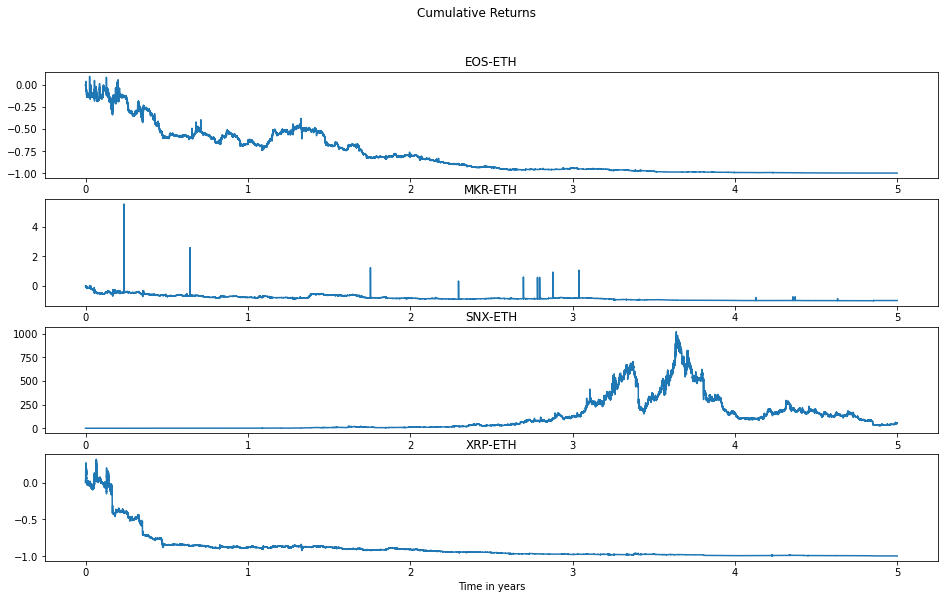

In [15]:
plot_multivariate_simulation(simulated_data=simulated_cumulative_returns,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Cumulative Returns')

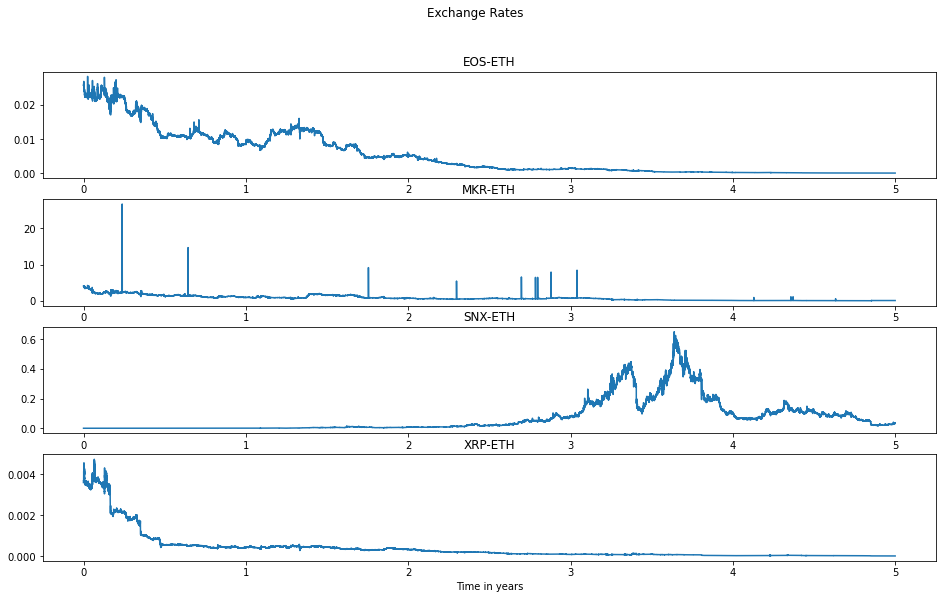

In [16]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [17]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
                                                                   tickers=tickers_with_ovl)

# Load Resampled Data

# Construct Agent Based Monetary Model

In [24]:
# TIME_RESOLUTION = TimeResolution.FIFTEEN_SECONDS
# DATA_SIM_RNG = 42

# Constants
STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

total_supply = 100000  # OVL
# base_wealth = 0.0002*100000  # OVL
base_wealth = 0.001*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = STEPS_MONTH
treasury = 0.0
sampling_interval = int(3600/time_resolution.in_seconds)


# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

# num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 50)
num_keepers = int(total_supply*0.005/base_wealth)
# num_traders = int(total_supply*0.005/base_wealth)
num_traders = 0
# num_holders = int(total_supply*0.5/base_wealth)
num_holders = 0
# num_snipers = min(int(total_supply*0.1/base_wealth), 100)
num_snipers = min(int(total_supply*0.1/base_wealth), 50)
# num_liquidators = int(total_supply*0.005/base_wealth)
num_liquidators = 4 * (len(tickers) + 1)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  quote_ticker=QUOTE_TICKER, 
                  ovl_quote_ticker=OVL_QUOTE_TICKER,
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
num_arbitrageurs = 50
num_snipers = 50
num_keepers = 5
num_traders = 0
num_holders = 0
num_liquidators = 20
total number of agents = 125
base_wealth = 100.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [25]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [26]:
number_of_steps_to_simulate

1051920

In [27]:
run_model(number_of_steps_to_simulate)

 18%|█▊        | 184383/1051921 [02:15<10:38, 1358.69it/s]


AssertionError: liquidate: position liquidation should result in burn of amount

In [28]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on EOS-ETH = 11
open positions on MKR-ETH = 31
open positions on OVL-ETH = 2
open positions on XRP-ETH = 2


# Extract Model Variables

In [29]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-EOS-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,f-EOS-ETH,f-MKR-ETH,...,Skew MKR-ETH,Skew OVL-ETH,Skew XRP-ETH,Number of Open Positions on EOS-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity
0,0.000000,0.0,0.0,0.000000,0.025924,4.1,0.000636,0.003586,0.025924,4.1,...,0.0,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0
1,0.000000,0.0,0.0,0.000000,0.025924,4.1,0.000636,0.003586,0.025924,4.1,...,0.0,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0
2,0.000000,0.0,0.0,0.000000,0.025924,4.1,0.000636,0.003586,0.025924,4.1,...,0.0,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0
3,0.000000,0.0,0.0,-0.006623,0.025924,4.1,0.000636,0.003610,0.025924,4.1,...,0.0,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0
4,-0.000989,0.0,0.0,-0.007298,0.025950,4.1,0.000636,0.003613,0.025924,4.1,...,0.0,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0


In [30]:
model_vars_df.to_parquet('model_vars.parq')

In [31]:
model_vars_df.memory_usage(deep=True)

Index                                      128
d-EOS-ETH                              1475080
d-MKR-ETH                              1475080
d-OVL-ETH                              1475080
d-XRP-ETH                              1475080
s-EOS-ETH                              1475080
s-MKR-ETH                              1475080
s-OVL-ETH                              1475080
s-XRP-ETH                              1475080
f-EOS-ETH                              1475080
f-MKR-ETH                              1475080
f-OVL-ETH                              1475080
f-XRP-ETH                              1475080
Skew EOS-ETH                           1475080
Skew MKR-ETH                           1475080
Skew OVL-ETH                           1475080
Skew XRP-ETH                           1475080
Number of Open Positions on EOS-ETH    1475080
Number of Open Positions on MKR-ETH    1475080
Number of Open Positions on OVL-ETH    1475080
Number of Open Positions on XRP-ETH    1475080
Supply       

In [32]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184385 entries, 0 to 184384
Data columns (total 23 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   d-EOS-ETH                            184385 non-null  float64
 1   d-MKR-ETH                            184385 non-null  float64
 2   d-OVL-ETH                            184385 non-null  float64
 3   d-XRP-ETH                            184385 non-null  float64
 4   s-EOS-ETH                            184385 non-null  float64
 5   s-MKR-ETH                            184385 non-null  float64
 6   s-OVL-ETH                            184385 non-null  float64
 7   s-XRP-ETH                            184385 non-null  float64
 8   f-EOS-ETH                            184385 non-null  float64
 9   f-MKR-ETH                            184385 non-null  float64
 10  f-OVL-ETH                            184385 non-null  float64
 11  f-XRP-ETH    

In [33]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [34]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [35]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

131490

In [36]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

525960

In [37]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

1440

In [38]:
525960 / monetary_model.schedule.steps

2.852540635524967

In [39]:
monetary_model.schedule.steps / 4 / 60 / 24

32.010937500000004

In [40]:
type(monetary_model.data_collector._agent_records)

dict

In [41]:
def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
    agent_vars_for_time_step = \
        monetary_model.data_collector._agent_records[time_step]
    column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
    return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [42]:
column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
column_names

['time_step', 'agent_id', 'Wealth']

In [43]:
monetary_model.data_collector.agent_reporters

{'Wealth': functools.partial(<function DataCollector._getattr at 0x7fb1520d9790>, 'wealth')}

In [44]:
df = \
    extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [45]:
monetary_model.data_collector._agent_records[quarter_year_index]

[(131490, 0, 22.105627242819985),
 (131490, 1, 32.65956826365481),
 (131490, 2, 100.0),
 (131490, 3, 100.0),
 (131490, 4, 100.0),
 (131490, 5, 100.0),
 (131490, 6, 100.0),
 (131490, 7, 100.0),
 (131490, 8, 100.0),
 (131490, 9, 24.912279280772857),
 (131490, 10, 100.0),
 (131490, 11, 100.0),
 (131490, 12, 100.0),
 (131490, 13, 100.0),
 (131490, 14, 100.0),
 (131490, 15, 100.0),
 (131490, 16, 100.0),
 (131490, 17, 100.0),
 (131490, 18, 46.7852754424231),
 (131490, 19, 97.90784703657992),
 (131490, 20, 100.0),
 (131490, 21, 100.0),
 (131490, 22, 100.0),
 (131490, 23, 100.0),
 (131490, 24, 100.0),
 (131490, 25, 100.0),
 (131490, 26, 100.0),
 (131490, 27, 24.484766970638425),
 (131490, 28, 106.2626011191057),
 (131490, 29, 80.0),
 (131490, 30, 100.0),
 (131490, 31, 100.0),
 (131490, 32, 100.0),
 (131490, 33, 100.0),
 (131490, 34, 100.0),
 (131490, 35, 100.0),
 (131490, 36, 41.55005302651139),
 (131490, 37, 74.54327211673574),
 (131490, 38, 100.0),
 (131490, 39, 100.0),
 (131490, 40, 100.0),

# Extract Agent Variables

In [46]:
# monetary_model.data_collector.__dict__

In [47]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

23048000


In [48]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [49]:
agent_vars_df.to_parquet(f'agent_vars.parq')

In [50]:
agent_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23048000 entries, (0, 0) to (184383, 124)
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Wealth  float64
dtypes: float64(1)
memory usage: 291.2 MB


In [51]:
agent_vars_df.tail(300)

Wealth
Step   AgentID            
184381 75        95.488972
       76        99.363042
       77        99.700144
       78        99.371698
       79        63.514233
...                    ...
184383 120      100.000000
       121      102.914380
       122      102.501744
       123      104.033424
       124      100.000000

[300 rows x 1 columns]

In [52]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [53]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [54]:
agent_wealth.shape

(125, 1)

In [55]:
agent_wealth.sum()

12256.770585157545

In [56]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [57]:
sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

[array([49.55995873]),
 array([55.08804129]),
 array([65.2191459]),
 array([67.07261465]),
 array([74.77834515]),
 array([76.30997183]),
 array([84.58701852]),
 array([92.4518295]),
 array([94.78006679]),
 array([95.48897239]),
 array([98.80645931]),
 array([98.92516951]),
 array([99.28201324]),
 array([99.55080927]),
 array([99.73024293]),
 array([99.73024293]),
 array([99.73024293]),
 array([99.73024293]),
 array([99.820081]),
 array([99.91]),
 array([99.91]),
 array([99.91]),
 array([99.91]),
 array([99.910027]),
 array([99.94]),
 array([99.97]),
 array([99.97]),
 array([99.97]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.])]

In [58]:
sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

[array([100.]), array([100.]), array([100.]), array([100.]), array([100.])]

In [59]:
sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

[array([91.39221019]),
 array([97.74294718]),
 array([98.90523011]),
 array([99.82010798]),
 array([99.82010798]),
 array([99.82010798]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.]),
 array([100.])]

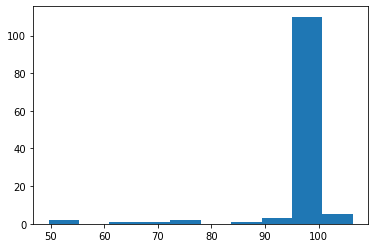

In [60]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

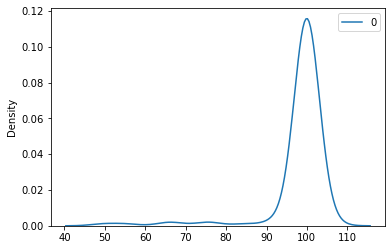

In [61]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [62]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [63]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

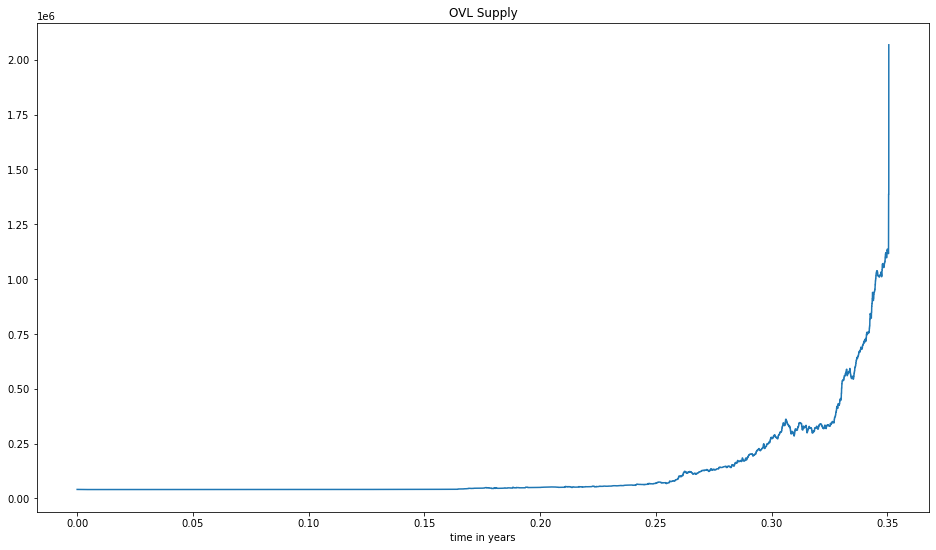

In [64]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

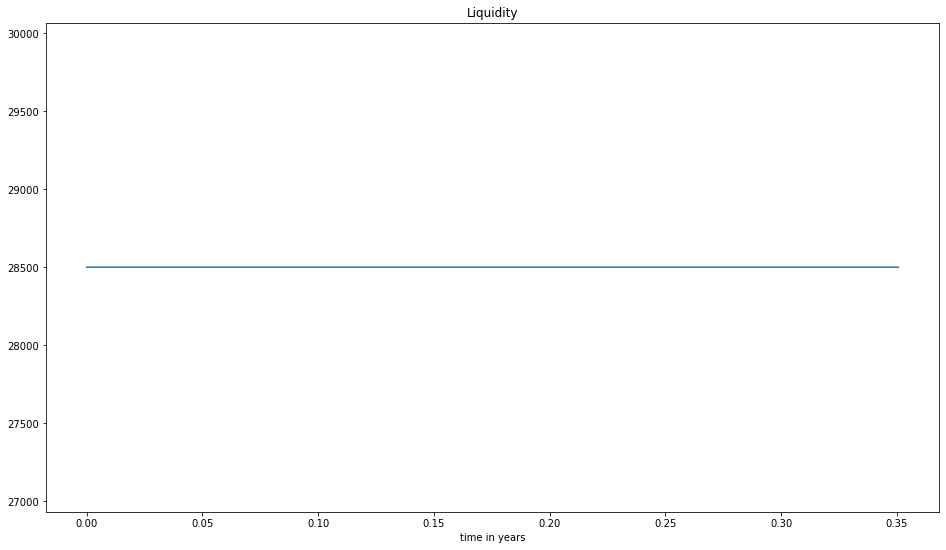

In [65]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

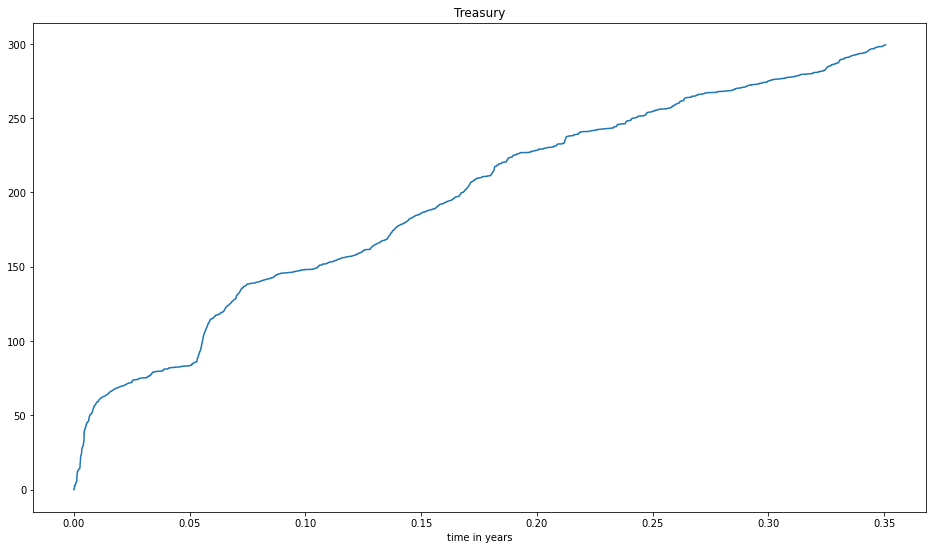

In [66]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

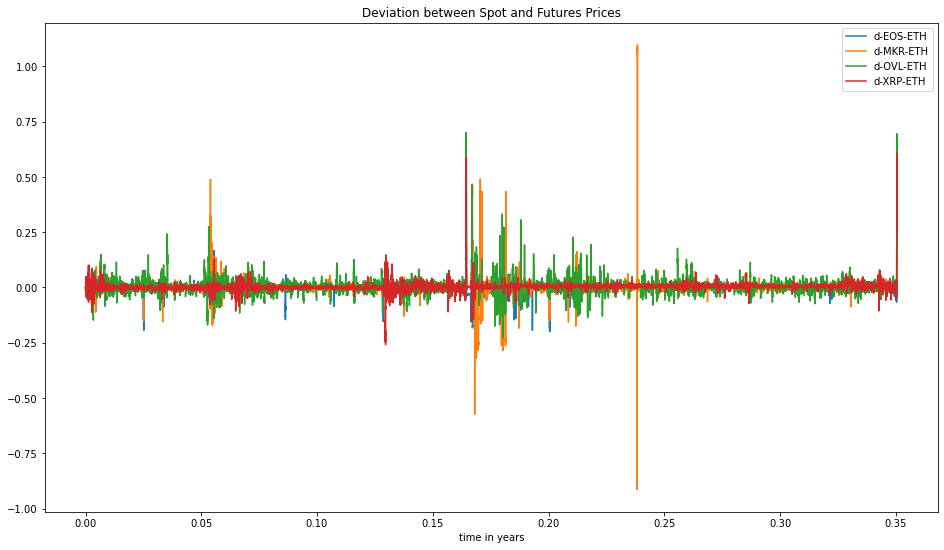

In [67]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

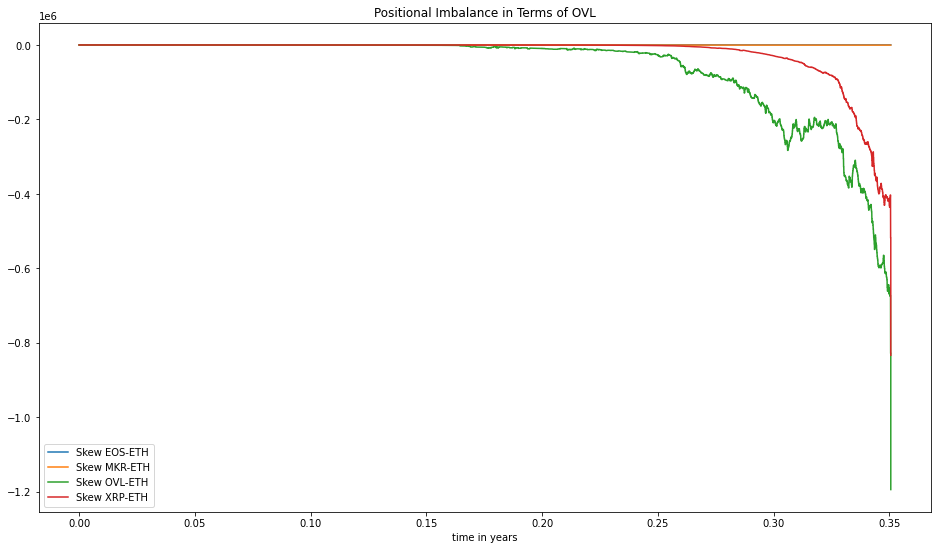

In [68]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [69]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[ 1.         -0.53867477]
 [-0.53867477  1.        ]]
[[ 1.         -0.54206134]
 [-0.54206134  1.        ]]


### Cumulative Returns

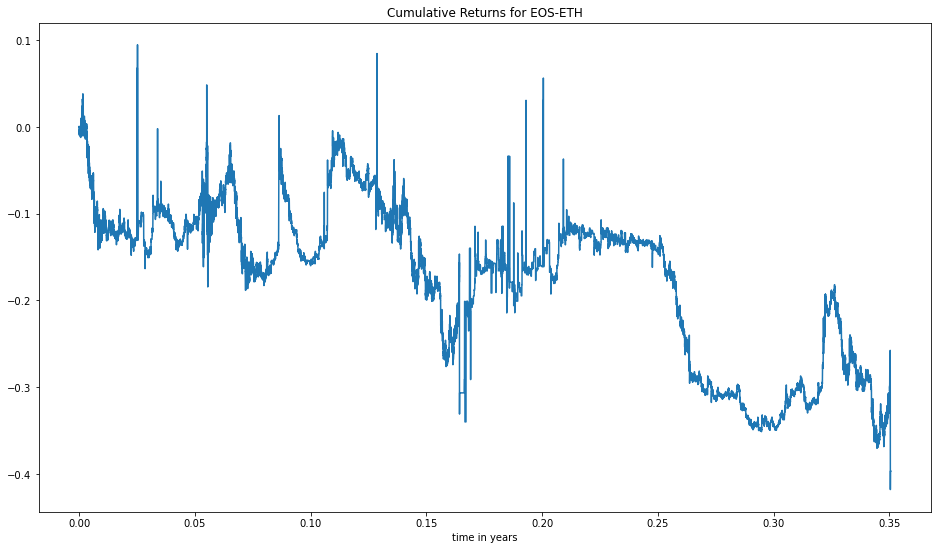

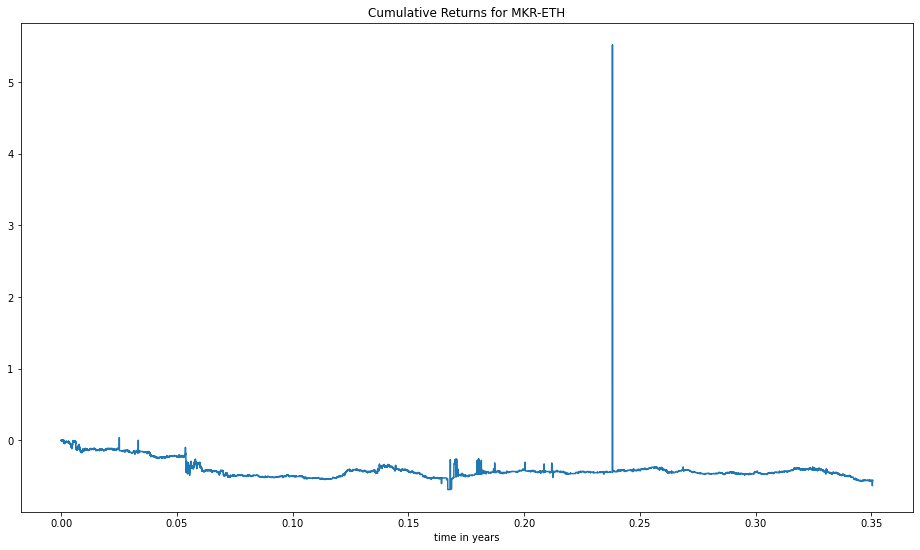

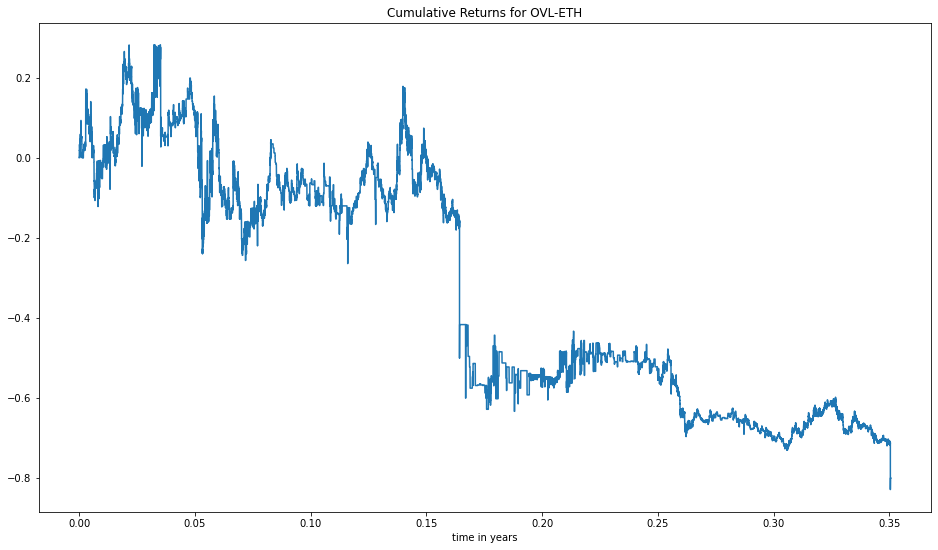

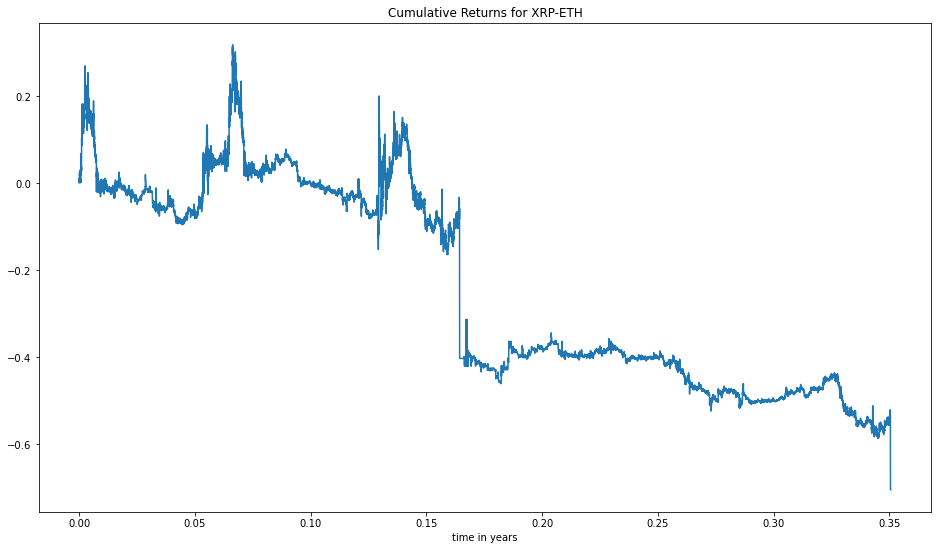

In [70]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

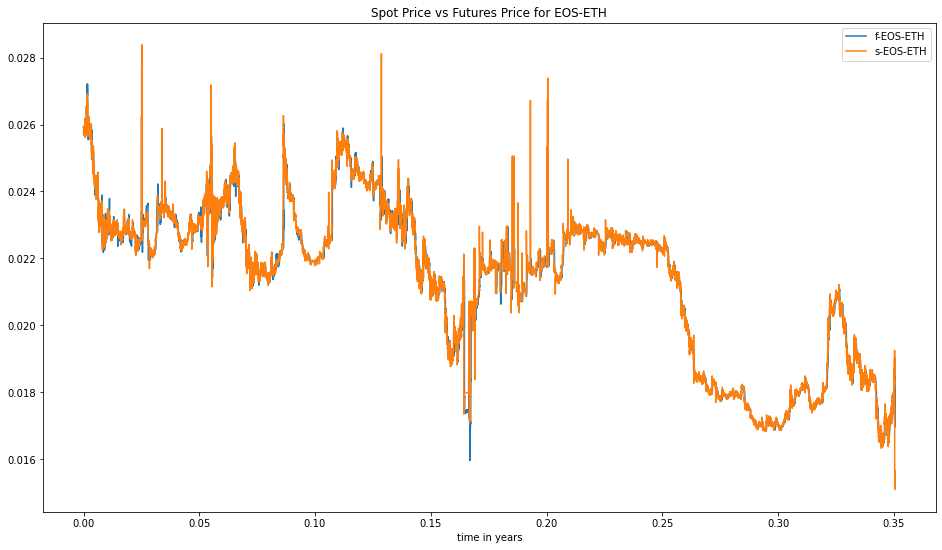

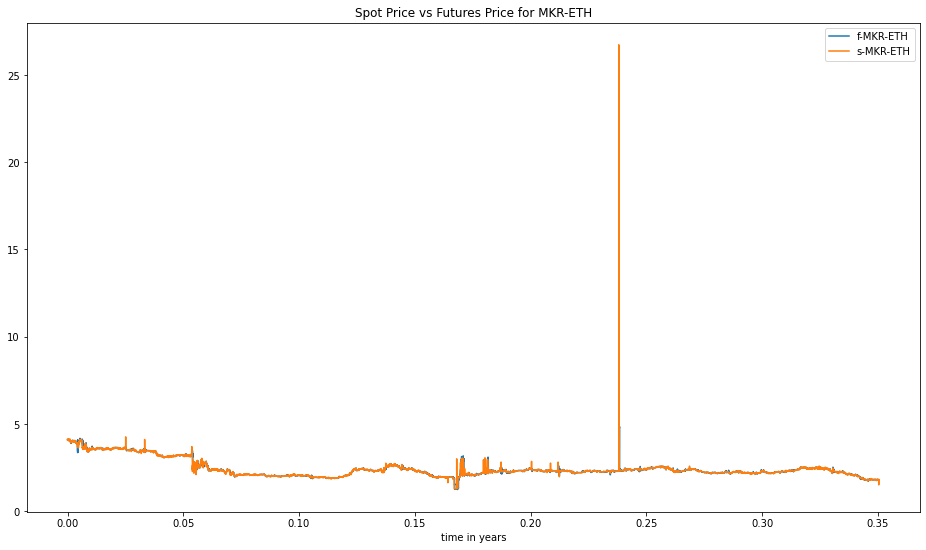

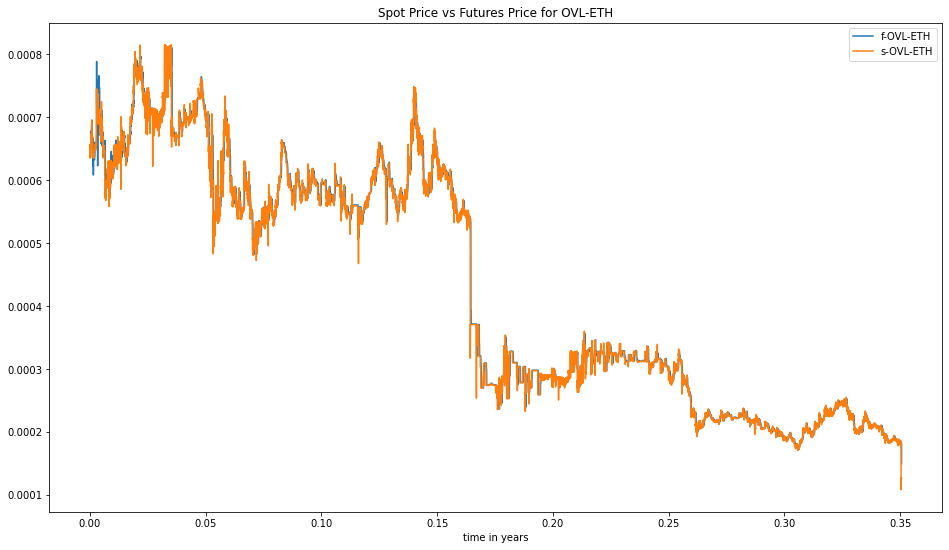

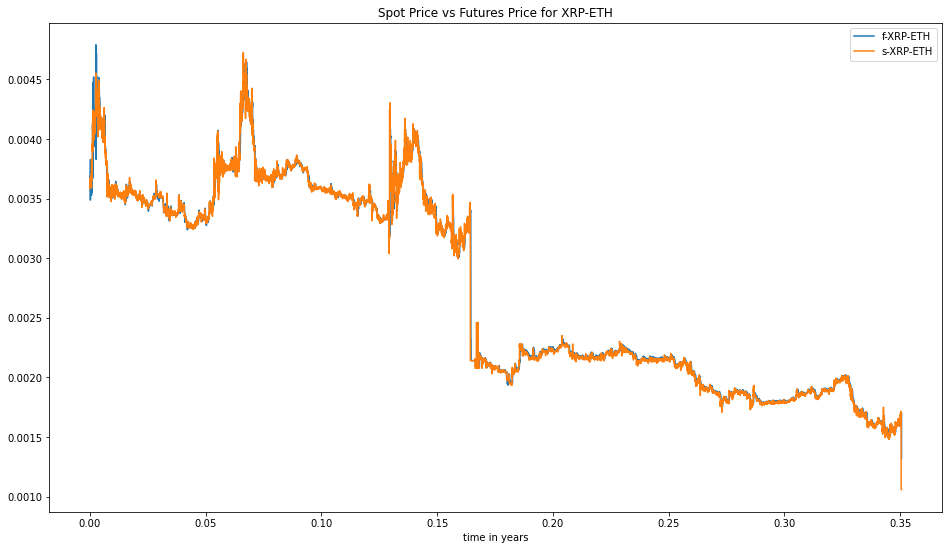

In [71]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [72]:
# model_vars_df.columns

In [73]:
# tickers_with_ovl[0]

In [74]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [75]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [76]:
# plt.close('all')